<a href="https://colab.research.google.com/github/jiaminho/RPH-HAC-Prediction/blob/jiamin_branch/HAC_autoencoder_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hospital Acquired Complications (HACs) Model Training and Evaluation

In [1]:
# mount google drive for google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path_prefix = '/content/drive/My Drive/CITS5553 Capstone Project/Capstone Project - HAC/hacks_project/'

Import libraries

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
pd.set_option('display.max_columns', None)  # None ensures all columns are shown
warnings.simplefilter(action='ignore', category=FutureWarning)

Read pre-processed data "all_encoded_df"

In [4]:
encoded_df = pd.read_csv(path_prefix + 'data/all_encoded_df.csv')

In [5]:
encoded_df.shape

(58976, 18495)

In [80]:
encoded_df['uti'] = encoded_df['uti'].replace({True: 1, False: 0})

In [97]:
print(encoded_df['uti'].value_counts())

0    52421
1     6555
Name: uti, dtype: int64


train test split

In [81]:
X = encoded_df.drop('uti', axis=1)
y = encoded_df['uti']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
# Scale data
scaler_original = StandardScaler()
X_scaled = scaler_original.fit_transform(X_train)

## Autoencoder

Dimensionality Reduction

In [83]:
encoding_dim = 100  # adjust this based on requirements
input_dim = X_scaled.shape[1]

# Define input layer
input_layer = Input(shape=(input_dim,))

# Define encoding layer
encoder = Dense(encoding_dim, activation='relu')(input_layer)

# Define decoding layer
#decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Create autoencoder model
autoencoder = Model(input_layer, encoder)

In [84]:
encoded = autoencoder.predict(X_scaled)
encoded_test = autoencoder.predict(X_test)

369/369 [==============================] - 1s 2ms/step


## Deep Neural Network (DNN)

In [85]:
# Adjust class weight
class_weight_0 = len(y_train) / (2 * np.sum(y_train == 0))
class_weight_1 = len(y_train) / (2 * np.sum(y_train == 1))
class_weights = {0: class_weight_0, 1: class_weight_1}

model = Sequential()
model.add(Dense(64, input_dim=encoding_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(encoded, y_train, epochs=100, batch_size=64, class_weight=class_weights)

Epoch 1/100
738/738 [==============================] - 4s 3ms/step - loss: 0.6941 - accuracy: 0.5483
Epoch 2/100
738/738 [==============================] - 2s 3ms/step - loss: 0.6569 - accuracy: 0.5238
Epoch 3/100
738/738 [==============================] - 3s 3ms/step - loss: 0.6302 - accuracy: 0.4976
Epoch 4/100
738/738 [==============================] - 3s 3ms/step - loss: 0.6196 - accuracy: 0.5063
Epoch 5/100
738/738 [==============================] - 2s 3ms/step - loss: 0.6137 - accuracy: 0.5038
Epoch 6/100
738/738 [==============================] - 2s 3ms/step - loss: 0.6034 - accuracy: 0.5163
Epoch 7/100
738/738 [==============================] - 2s 3ms/step - loss: 0.5982 - accuracy: 0.5199
Epoch 8/100
738/738 [==============================] - 2s 3ms/step - loss: 0.5927 - accuracy: 0.5423
Epoch 9/100
738/738 [==============================] - 2s 3ms/step - loss: 0.5889 - accuracy: 0.5517
Epoch 10/100
738/738 [==============================] - 3s 3ms/step - loss: 0.5827 - accura

In [86]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                6464      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                

Plot Learning Curves

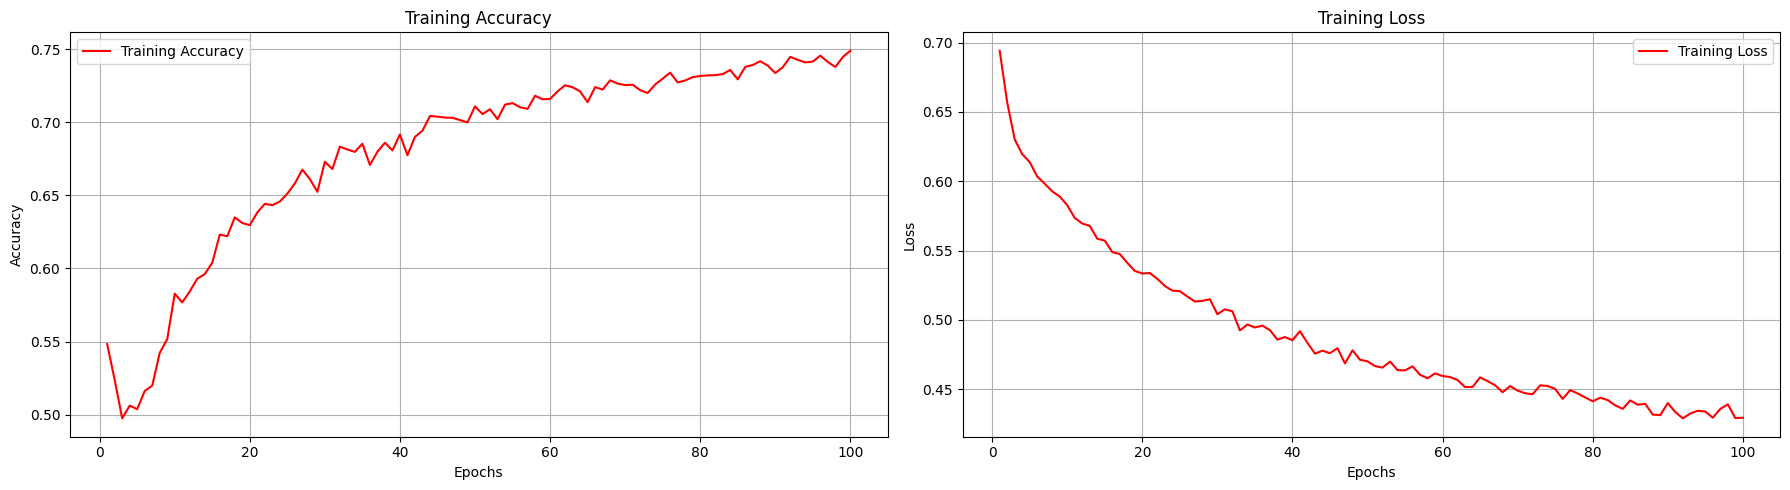

In [87]:
def plot_learning_curves(history):
    # Extract the training and validation losses & accuracies
    train_loss = history.history['loss']
    #val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(18, 5))

    # Plot training and validation accuracies
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    #plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot training and validation losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    #plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

**DNN Model Evaluation**

In [88]:
# train and test predictions
dnn_y_test_pred = model.predict(encoded_test)
dnn_y_train_pred = model.predict(encoded)

1475/1475 [==============================] - 2s 1ms/step


In [90]:
print(classification_report(y_test, dnn_y_test_pred.round()))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86     10565
           1       0.15      0.26      0.19      1231

    accuracy                           0.76     11796
   macro avg       0.53      0.54      0.53     11796
weighted avg       0.83      0.76      0.79     11796



In [91]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

54.30% - Balanced accuracy Test
85.87% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

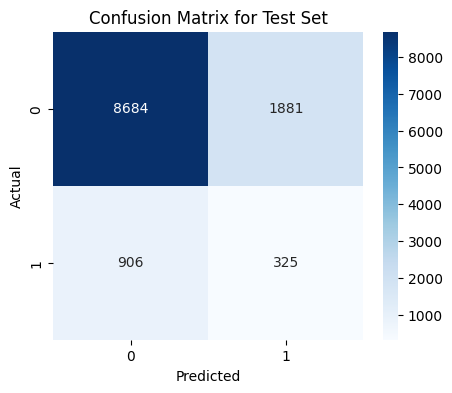

In [106]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, dnn_y_test_pred.round())
train_cm = confusion_matrix(y_train, dnn_y_train_pred.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## Random Forest

In [92]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(encoded, y_train)

RandomForestClassifier(random_state=42)

In [93]:
rf_y_pred = rf.predict(encoded_test)
rf_y_train_pred = rf.predict(encoded)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94     10565
           1       0.00      0.00      0.00      1231

    accuracy                           0.90     11796
   macro avg       0.45      0.50      0.47     11796
weighted avg       0.80      0.90      0.85     11796



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, rf_y_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, rf_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

50.00% - Balanced accuracy Test
99.98% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

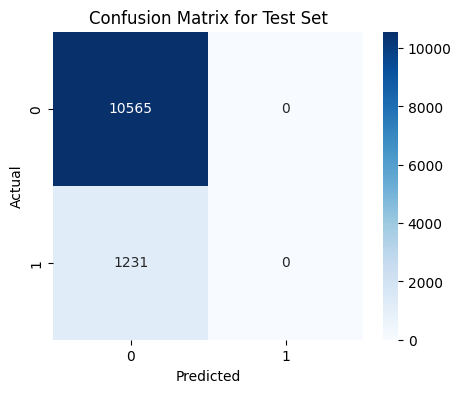

In [105]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, rf_y_pred.round())
train_cm = confusion_matrix(y_train, rf_y_train_pred.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## XGBoost

In [95]:
import xgboost as xgb

# Create and train the model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(encoded, y_train)

# predict using test set
xgb_predictions = xgb_model.predict(encoded_test)
xgb_train_predictions = xgb_model.predict(encoded)

# show classification report
print("XGBoost Classification Report:\n")
print(classification_report(y_test, xgb_predictions))

XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.90      1.00      0.94     10565
           1       0.00      0.00      0.00      1231

    accuracy                           0.90     11796
   macro avg       0.45      0.50      0.47     11796
weighted avg       0.80      0.90      0.85     11796



In [96]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, xgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, xgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

49.99% - Balanced accuracy Test
72.88% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

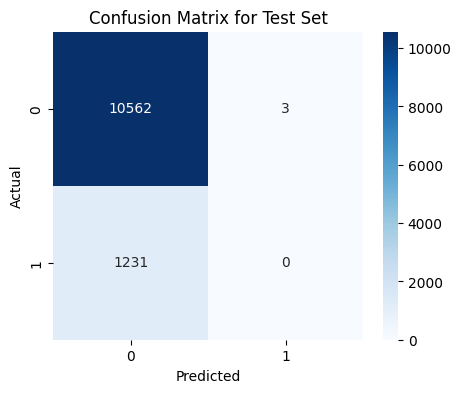

In [104]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, xgb_predictions.round())
train_cm = confusion_matrix(y_train, xgb_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## LightGBM

In [98]:
import lightgbm as lgb

# Create and train the model
lgb_model = lgb.LGBMClassifier(objective="binary", random_state=42)
lgb_model.fit(encoded, y_train)

# predict using test set
lgb_predictions = lgb_model.predict(encoded_test)
lgb_train_predictions = lgb_model.predict(encoded)

# show classification report
print("LightGBM Classification Report:\n")
print(classification_report(y_test, lgb_predictions))

[LightGBM] [Info] Number of positive: 5324, number of negative: 41856
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 47180, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112844 -> initscore=-2.062010
[LightGBM] [Info] Start training from score -2.062010
LightGBM Classification Report:

              precision    recall  f1-score   support

           0       0.90      1.00      0.94     10565
           1       0.00      0.00      0.00      1231

    accuracy                           0.90     11796
   macro avg       0.45      0.50      0.47     11796
weighted avg       0.80      0.90      0.85     11796



In [99]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, lgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, lgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

50.00% - Balanced accuracy Test
53.19% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

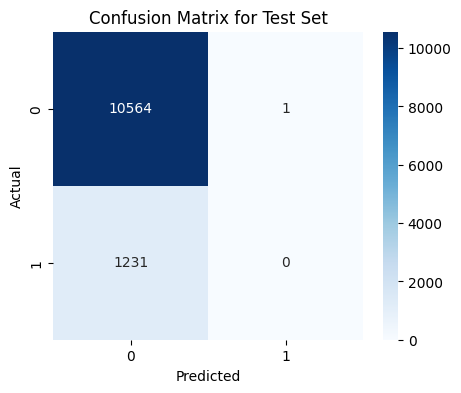

In [103]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, lgb_predictions.round())
train_cm = confusion_matrix(y_train, lgb_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')